# Praca domowa 4 Marcin Wilk

In [139]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import poisson,expon
from sklearn.metrics import accuracy_score

## Zbiór danych apartments z R-owego pakietu DALEX

Pierwszym zbiorem danych, który będziemy rozważać będzie zbiór danych o cenach za metr kwadratowy poszczególnych mieszkań w zależności od czasu budowy, powierzchni, piętra, liczby pokoi oraz dzielnicy. Naszym zadaniem będzie więc regresja i prognoza zmiennej m2.price.

In [140]:
apartments = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\Wstęp do uczenia maszynowego\\Laby\\apartments.csv")

In [141]:
apartments.head(10)

,Unnamed: 0,m2.price,construction.year,surface,floor,no.rooms,district
0,1,5897,1953,25,3,1,Srodmiescie
1,2,1818,1992,143,9,5,Bielany
2,3,3643,1937,56,1,2,Praga
3,4,3517,1995,93,7,3,Ochota
4,5,3013,1992,144,6,5,Mokotow
5,6,5795,1926,61,6,2,Srodmiescie
6,7,2983,1970,127,8,5,Mokotow
7,8,2346,1985,105,8,4,Ursus
8,9,4745,1928,145,6,6,Srodmiescie
9,10,4284,1949,112,9,4,Srodmiescie


Pierwsza ze zmiennych jest po prostu numeracją obserwacji, więc od razu ją wyrzucamy.

In [142]:
apartments = apartments.iloc[:,1:]

In [143]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2.price           1000 non-null   int64 
 1   construction.year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no.rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


In [144]:
apartments["district"].value_counts()

Mokotow        107
Wola           106
Ursus          105
Ursynow        103
Srodmiescie    100
Bemowo          98
Zoliborz        97
Bielany         96
Ochota          96
Praga           92
Name: district, dtype: int64

Pierwszym problemem, który napotykamy jest zmienna kategoryczna district. Musimy użyć jakiegoś encodera by zamienić ją na zmienną numeryczną. Użyjemy do tego Generalized Linear Mixed Model Encoder, który dobrze sprawdził się w jednej z poprzednich prac domowych.

In [145]:
encoder = ce.GLMMEncoder()
apartments["district"] = encoder.fit_transform(X=apartments["district"],y=apartments["m2.price"])

In [146]:
apartments.describe()

,m2.price,construction.year,surface,floor,no.rooms,district
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3487.019000,1964.823000,85.590000,5.623000,3.360000,-0.039059
std,906.691651,25.831511,37.874799,2.899876,1.381415,679.749417
min,1607.000000,1920.000000,20.000000,1.000000,1.000000,-515.342877
25%,2857.000000,1943.000000,53.000000,3.000000,2.000000,-488.587014
50%,3386.000000,1965.000000,85.500000,6.000000,3.000000,-413.964588
75%,4018.250000,1988.000000,118.000000,8.000000,4.000000,366.037975
max,6595.000000,2010.000000,150.000000,10.000000,6.000000,1684.064618


Widzimy, że dane nie mają podobnych rzędów wielkości, ich skala może stanowić więc problem dla algorytmu. Z tego powodu rozważymy 2 rodzaje regresji, jeden ze standaryzacją zmiennych, drugi bez.

In [171]:
y=apartments["m2.price"]
X=apartments.iloc[:,1:]

In [148]:
svr_raw = SVR()
svr_scaled = make_pipeline(StandardScaler(), SVR())

Dokładność obu tych modeli porównamy za pomocą kroswalidacji oraz miary RMSE. Użyjemy do tego modeli z domyślnymi hiperparametrami. Będziemy je potem stroić tylko dla jednego z tych modeli.

In [149]:
def RMSE(estimator, X, y):
    estimator.fit(X, y)
    y_hat=estimator.predict(X)
    return np.sqrt(np.mean((y-y_hat)**2))

In [150]:
raw_score=cross_val_score(svr_raw,X,y,cv=10,scoring=RMSE)
scaled_score=cross_val_score(svr_scaled,X,y,cv=10,scoring=RMSE)

Zobaczmy na boxplotach jak prezentują się wartości RMSE.

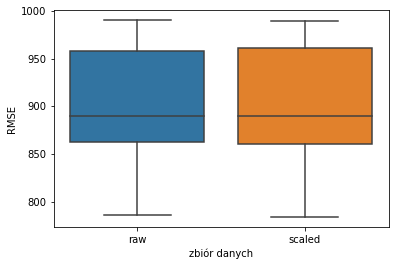

In [151]:
apartments_rmse=pd.melt(pd.DataFrame({"raw":raw_score,"scaled":scaled_score }))
apartments_rmse["zbiór danych"]=apartments_rmse["variable"]
apartments_rmse["RMSE"]=apartments_rmse["value"]
sns.boxplot(x="zbiór danych", y="RMSE", data=apartments_rmse)
plt.show()

Zobaczmy jakie wartości miały poszczególne iteracje kroswalidacji.

In [152]:
pd.DataFrame({"raw":raw_score,"scaled":scaled_score })

,raw,scaled
0,861.119311,858.570931
1,785.415169,783.342162
2,990.807683,989.990671
3,980.576528,981.239144
4,865.705852,865.791052
5,895.263576,895.911754
6,883.660744,883.368203
7,926.278501,929.513307
8,841.831792,841.430151
9,967.917231,972.007987


O dziwo standaryzacja nie miała prawie w ogóle wpływu na wyniki regresji i błąd dopasowania. Mimo tego że SVM jest czuły na skalę, to w tym przypadku oba modele spisują się bardzo podobnie. Spróbujmy teraz dostroić hiperparametry w modelu standaryzowanym i porównać go z modelem niestrojonym.

In [172]:
degree=[1,2,3]
kernel=["rbf","poly"]
gamma=["auto","scale"]
C=expon(1)
param_grid = dict(svr__degree=degree,svr__gamma=gamma, svr__C=C,svr__kernel=kernel)

In [173]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2)

In [175]:
random = RandomizedSearchCV(estimator=svr_scaled, param_distributions=param_grid, cv = 10, n_jobs=-1, random_state=0,scoring=RMSE,n_iter=100)

random_result = random.fit(X_train, y_train)

print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 889.462418 using {'svr__C': 1.0117832346223192, 'svr__degree': 2, 'svr__gamma': 'scale', 'svr__kernel': 'poly'}


Jak widzimy najlepsze RMSE na zbiorze testowym wynosi około 889, bardzo podobnie jak w przypadku wszystkich wyników kroswalidacji. Parametr C odpowiedzialny za karę nie różni się zbytnio od domyślnego, równego 1. Co ciekawe strojenie wybrało zupełnie inne jądro od domyślnego gaussowskiego, optymalnym jest jądro wielomianowe o maksymalnym stopniu 2.

## Zbiór danych urine

Drugim z rozważanych zbiorów danych będzie zbiór urine. Naszym celem bedzie prognozowanie obecności kryształów (zmienna presence o wartościach yes/no). Sześcioma zmiennymi objaśniającymi są właściwości fizykochemiczne moczu, będące wszystkie zmiennymi numerycznymi. Naszym zadaniem nie będzie więc regresja, a klasyfikacja.

In [156]:
urine=pd.read_table("C:\\Users\\Lenovo\\Desktop\\Wstęp do uczenia maszynowego\\Laby\\urine.txt",sep=" ")

In [157]:
urine.head(10)

,presence,sg,ph,mosm,mmho,urea,calcium
0,no,1.017,5.74,577,20.0,296,4.49
1,no,1.008,7.20,321,14.9,101,2.36
2,no,1.011,5.51,408,12.6,224,2.15
3,no,1.005,6.52,187,7.5,91,1.16
4,no,1.020,5.27,668,25.3,252,3.34
5,no,1.012,5.62,461,17.4,195,1.40
6,no,1.029,5.67,1107,35.9,550,8.48
7,no,1.015,5.41,543,21.9,170,1.16
8,no,1.021,6.13,779,25.7,382,2.21
9,no,1.011,6.19,345,11.5,152,1.93


In [158]:
urine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   presence  77 non-null     object 
 1   sg        77 non-null     float64
 2   ph        77 non-null     float64
 3   mosm      77 non-null     int64  
 4   mmho      77 non-null     float64
 5   urea      77 non-null     int64  
 6   calcium   77 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 4.3+ KB


Ramka nie ma braków danych oraz wszystkie zmienne objaśniające są numeryczne. Przekodujemy jedynie zmienną presence w sposób: yes->1 no->0.

In [159]:
urine["presence"]=(urine["presence"]=="yes").apply(int)

In [160]:
urine["presence"].value_counts()

0    44
1    33
Name: presence, dtype: int64

Klasy przekonwertowały się poprawnie, są w miarę równoliczne, zatem accuracy powinno być dobrą miarą dopasowania modelu. Podobnie jak w poprzednim przykładzie utworzymy 2 modele, jeden ze standaryzacją, drugi bez, następnie porównamy je za pomocą kroswalidacji.

In [161]:
urine.describe()

,presence,sg,ph,mosm,mmho,urea,calcium
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.428571,1.018026,6.040649,613.610390,20.905195,262.402597,4.160390
std,0.498117,0.007313,0.722068,239.473719,8.004142,130.486363,3.296907
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000
25%,0.000000,1.012000,5.530000,410.000000,14.300000,159.000000,1.450000
50%,0.000000,1.018000,5.940000,594.000000,21.400000,255.000000,3.160000
75%,1.000000,1.024000,6.400000,803.000000,27.000000,362.000000,6.190000
max,1.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000


Tutaj również mamy problem niewyskalowanych zmiennych. W poprzednim przykładzie nie wpłynęło to zbytnio na poprawność regresji, lobaczymy jak będzie w przypadku klasyfikacji binarnej.

In [184]:
y=urine["presence"]
X=urine.iloc[:,1:]

In [163]:
svc_raw = SVC()
svc_scaled = make_pipeline(StandardScaler(), SVC())

In [164]:
raw_score=cross_val_score(svc_raw,X,y,cv=10)
scaled_score=cross_val_score(svc_scaled,X,y,cv=10)

Zobaczmy jak wyniki klasyfikacji prezentują się na boxplotach.

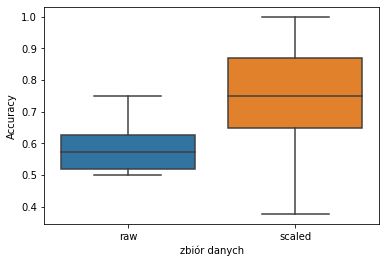

In [165]:
urine_acc=pd.melt(pd.DataFrame({"raw":raw_score,"scaled":scaled_score }))
urine_acc["zbiór danych"]=urine_acc["variable"]
urine_acc["Accuracy"]=urine_acc["value"]
sns.boxplot(x="zbiór danych", y="Accuracy", data=urine_acc)
plt.show()

Widzimy wyraźnie, że w tym przypadku standaryzacja zmiennych bardzo pomogła w prognozowaniu obecności kryształów. Oba boxploty są rozłączne, dokładność dla danych standaryzowanych jest istotnie większa od tych bez niej. Jest to rezultat, którego spodziewaliśmy się właśnie po SVM-ie, który jest wrażliwy na skalę danych. Spróbujmy jeszcze dopasować lepsze hiperparametry dla zbioru standaryzowanego. 

In [166]:
degree=[1,2,3]
kernel=["rbf","poly"]
gamma=["auto","scale"]
C=expon(1)
param_grid = dict(svr__degree=degree,svr__gamma=gamma, svr__C=C,svr__kernel=kernel)

In [186]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2)

In [187]:
random = RandomizedSearchCV(estimator=svr_scaled, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state=0,n_iter=100)

random_result = random.fit(X_train, y_train)

print("Best: %f using %s" % (1-random_result.best_score_, random_result.best_params_))

Best: 0.769309 using {'svr__C': 1.1258744118305428, 'svr__degree': 1, 'svr__gamma': 'scale', 'svr__kernel': 'poly'}


Widzimy tutaj, że strojenie hiperparametrów niewiele poprawia nam dokładność. Penalizacja parametrem C została w okolicy wartości domyślnej. Lepszym jądrem od gaussowskiego okazało się ponownie wielomianowe, tym razem jednak z niższym maksymalnym stopniem równym 1.